In [1]:
import numpy as np
import gmsh
from scipy.linalg import eigh 
import matplotlib.pyplot as plt


In [2]:
#MDF_COMMENT haganme grande los dibujitos
plt.rc('figure', figsize=(15,8))
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

In [3]:
Largo = 1
Area = 10e-4 
Inercia = 10e-8
densidad = 7850
Modulo_E = 210e9

Numero_de_elementos = 15

<div style='background-color: #999900'> te falta el estudio de convergencia no ? </div>

In [4]:
def frec_de_N (Numero_de_elementos):
    Largo_elemento = Largo/Numero_de_elementos 

    n = (Numero_de_elementos*2) + 2 
    Matriz_rigidez = np.zeros((n,n)) 
    Matriz_masa = np.zeros((n,n)) 

    for i in range(Numero_de_elementos):

        p = i
        j = i+1

        #matriz de masa concentrada
    #     Matriz_m = ((densidad*Largo_elemento*Area)/24) * np.array([
    #                                                               [12,0,0,0],
    #                                                               [0,Largo_elemento**2,0,0],
    #                                                               [0,0,12,0],
    #                                                               [0,0,0,Largo_elemento**2]
    #                                                               ])

        #matriz de masa consistente

        Matriz_m = ((densidad*Largo_elemento*Area)/420) * np.array([
                  [156,22*Largo_elemento,54,-13*Largo_elemento],
                  [22*Largo_elemento,4*Largo_elemento**2,13*Largo_elemento,-3*Largo_elemento**2],
                  [54,13*Largo_elemento,156,-22*Largo_elemento],
                  [-13*Largo_elemento,-3*Largo_elemento**2,-22*Largo_elemento,4*Largo_elemento**2]
                  ])

        #Matriz de rigidez
        Matriz_local = ((Modulo_E*Inercia)/(Largo_elemento**3)) * np.array([
                    [12,  6*Largo_elemento,  -12,   6*Largo_elemento],
                    [6*Largo_elemento,   4*Largo_elemento**2,   -6*Largo_elemento,   2*Largo_elemento**2],
                    [-12,    -6*Largo_elemento,   12,   -6*Largo_elemento],
                    [6*Largo_elemento,  2*Largo_elemento**2,   -6*Largo_elemento,   4*Largo_elemento**2]
                   ])


        A_G = np.array([p*2,p*2+1],dtype = int)
        B_G = np.array([j*2,j*2+1],dtype = int) 
        A_L = np.array([0,1],dtype = int)
        B_L = np.array([2,3],dtype = int)


        Matriz_rigidez[np.ix_(A_G,A_G)] +=  Matriz_local [np.ix_(A_L,A_L)]
        Matriz_rigidez[np.ix_(B_G,B_G)] +=  Matriz_local [np.ix_(B_L,B_L)]
        Matriz_rigidez[np.ix_(A_G,B_G)] +=  Matriz_local [np.ix_(A_L,B_L)]
        Matriz_rigidez[np.ix_(B_G,A_G)] +=  Matriz_local [np.ix_(B_L,A_L)]

        Matriz_masa[np.ix_(A_G,A_G)] +=  Matriz_m [np.ix_(A_L,A_L)]
        Matriz_masa[np.ix_(B_G,B_G)] +=  Matriz_m [np.ix_(B_L,B_L)]
        Matriz_masa[np.ix_(A_G,B_G)] +=  Matriz_m [np.ix_(A_L,B_L)]
        Matriz_masa[np.ix_(B_G,A_G)] +=  Matriz_m [np.ix_(B_L,A_L)]
    

    R = np.arange(2,n)
    Matriz_rigidez_reducida = Matriz_rigidez[np.ix_(R,R)]
    Matriz_masa_reducida = Matriz_masa[np.ix_(R,R)]
    w, vl = eigh(Matriz_rigidez_reducida, Matriz_masa_reducida)
#MDF_COMMENT    vl_normalizado=vl/vl[2*(Numero_de_elementos)-2,:]
    vl_normalizado = vl[::2]/vl[::2].max()
    return (vl_normalizado, w)

<div style='background-color: #999900'>quedó muy largo no ?</div>

In [5]:
#MDF_COMMENT capaz tenes que instalar tqdm, descomenta:
# !pip install tqdm
from tqdm.notebook import tqdm_notebook
#MDF_COMMENT voy a guardar los 4 primeros modos:
vlns = []
modemax  = 6
minelem = 1
ws = np.nan*np.ones([Numero_de_elementos-minelem+1, modemax])

In [6]:
progress = tqdm_notebook(range(minelem,Numero_de_elementos+1))
for N in progress:
    vln, w = frec_de_N(N)
    imax = min(modemax, len(w))
    vlns.append(vln[:,:imax])
    ws[N-minelem, :imax] = np.sqrt(w[:imax])/(2*np.pi)
    

  0%|          | 0/15 [00:00<?, ?it/s]

In [7]:
ws.shape

(15, 6)

In [8]:
np.linspace(minelem, Numero_de_elementos, Numero_de_elementos-minelem+1)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15.])

Text(0.5, 0, 'numero de elementos')

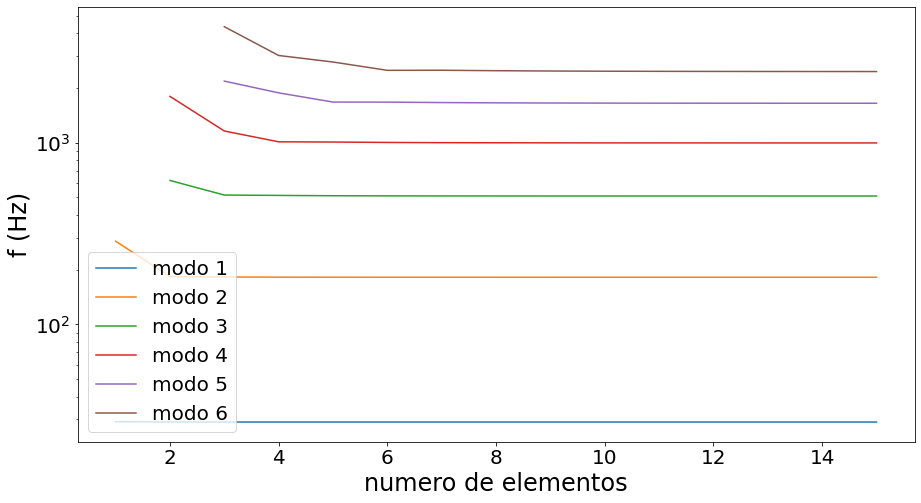

In [9]:
for i in range(modemax):
    plt.plot(
        np.linspace(minelem, Numero_de_elementos, Numero_de_elementos-minelem+1),
        ws[:,i],
        label='modo %d' % (i+1))
plt.legend(fontsize=20) 
ax = plt.gca()
ax.set_yscale('log')
ax.set_ylabel('f (Hz)')
ax.set_xlabel('numero de elementos')

In [10]:
#MDF_COMMENT Modos = np.zeros((Numero_de_elementos,Numero_de_elementos*2))
#MDF_COMMENT o = 0
#MDF_COMMENTfor i in range(len(vl_normalizado[0,:])):
#MDF_COMMENT    if i%2 == 0:
#MDF_COMMENT        Modos[o] = vl_normalizado[i]
#MDF_COMMENT        o += 1


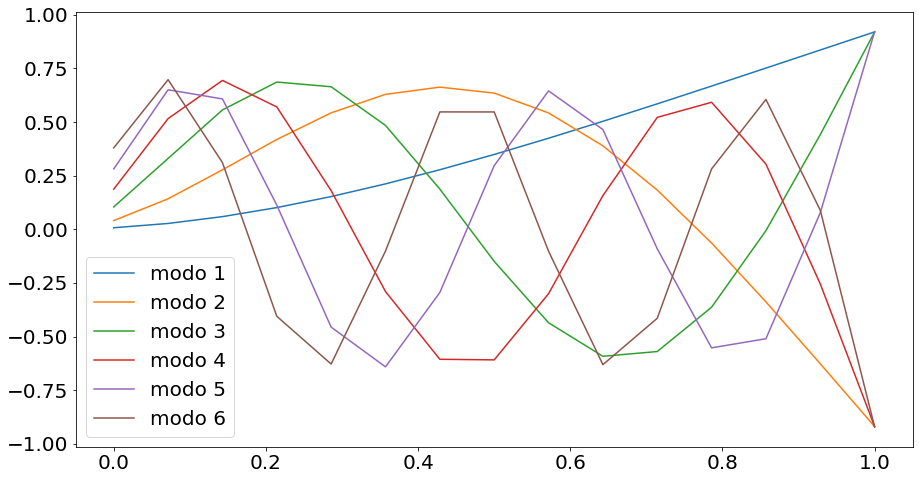

In [11]:
#for vl in vls:
for i in range(modemax):
    #MDF_COMMENT distancias = np.linspace(0,Largo,(len(Modos[:,0])+1))
    distancias = np.linspace(0, Largo, len(vlns[-1][:]))
#for i in range(3): #en(vl[:,0])):
    #VL = Modos[:,i].reshape(-1,1)
    #modo = np.append(np.array([0]),VL)
    plt.plot(distancias, vlns[-1][:,i] , label='modo %d' % (i+1) )
    #plt.plot(distancias,modo,'o',label = i)  
plt.legend(fontsize=20)        
plt.show()